In [1]:
# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

import os, sys, gc, warnings, random

import datetime
import dateutil.relativedelta

# Data manipulation
import pandas as pd 
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve, roc_curve
from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold, GroupKFold
from sklearn.ensemble import RandomForestClassifier

import lightgbm as lgb

from tqdm.notebook import trange, tqdm

from IPython.display import display

%matplotlib inline

pd.options.display.max_rows = 10000
pd.options.display.max_columns = 1000
pd.options.display.max_colwidth = 1000

In [2]:
def seed_everything(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    
SEED = 42
seed_everything(SEED)

In [3]:
TOTAL_THRES = 300

'''
    입력인자로 받는 year_month에 대해 고객 ID별로 총 구매액이
    구매액 임계값을 넘는지 여부의 binary label을 생성하는 함수
'''
def generate_label(df, year_month, total_thres=TOTAL_THRES, print_log=False):
    df = df.copy()
    
    # year_month에 해당하는 label 데이터 생성
    df['year_month'] = df['order_date'].dt.strftime('%Y-%m')
    df.reset_index(drop=True, inplace=True)

    # year_month 이전 월의 고객 ID 추출
    cust = df[df['year_month']<year_month]['customer_id'].unique()
    # year_month에 해당하는 데이터 선택
    df = df[df['year_month']==year_month]
    
    # label 데이터프레임 생성
    label = pd.DataFrame({'customer_id':cust})
    label['year_month'] = year_month
    
    # year_month에 해당하는 고객 ID의 구매액의 합 계산
    grped = df.groupby(['customer_id','year_month'], as_index=False)[['total']].sum()
    
    # label 데이터프레임과 merge하고 구매액 임계값을 넘었는지 여부로 label 생성
    label = label.merge(grped, on=['customer_id','year_month'], how='left')
    label['total'].fillna(0.0, inplace=True)
    label['label'] = (label['total'] > total_thres).astype(int)

    # 고객 ID로 정렬
    label = label.sort_values('customer_id').reset_index(drop=True)
    if print_log: print(f'{year_month} - final label shape: {label.shape}')
    
    return label

In [4]:
def print_score(label, pred, prob_thres=0.5):
    print('Precision: {:.5f}'.format(precision_score(label, pred>prob_thres)))
    print('Recall: {:.5f}'.format(recall_score(label, pred>prob_thres)))
    print('F1 Score: {:.5f}'.format(f1_score(label, pred>prob_thres)))
    print('ROC AUC Score: {:.5f}'.format(roc_auc_score(label, pred)))

In [5]:
def feature_preprocessing(train, test, features, do_imputing=True):
    x_tr = train.copy()
    x_te = test.copy()
    
    # 범주형 피처 이름을 저장할 변수
    cate_cols = []

    # 레이블 인코딩
    for f in features:
        if x_tr[f].dtype.name == 'object': # 데이터 타입이 object(str)이면 레이블 인코딩
            cate_cols.append(f)
            le = LabelEncoder()
            # train + test 데이터를 합쳐서 레이블 인코딩 함수에 fit
            le.fit(list(x_tr[f].values) + list(x_te[f].values))
            
            # train 데이터 레이블 인코딩 변환 수행
            x_tr[f] = le.transform(list(x_tr[f].values))
            
            # test 데이터 레이블 인코딩 변환 수행
            x_te[f] = le.transform(list(x_te[f].values))

    print('categorical feature:', cate_cols)

    if do_imputing:
        # 중위값으로 결측치 채우기
        imputer = SimpleImputer(strategy='median')

        x_tr[features] = imputer.fit_transform(x_tr[features])
        x_te[features] = imputer.transform(x_te[features])
    
    return x_tr, x_te

In [6]:
def feature_engineering1(df, year_month):
    df = df.copy()
    
    # year_month 이전 월 계산
    d = datetime.datetime.strptime(year_month, "%Y-%m")
    prev_ym = d - dateutil.relativedelta.relativedelta(months=1)
    prev_ym = prev_ym.strftime('%Y-%m')
    
    # train, test 데이터 선택
    train = df[df['order_date'] < prev_ym]
    test = df[df['order_date'] < year_month]
    
    # train, test 레이블 데이터 생성
    train_label = generate_label(df, prev_ym)[['customer_id','year_month','label']]
    test_label = generate_label(df, year_month)[['customer_id','year_month','label']]
    
    # group by aggregation 함수 선언
    agg_func = ['mean','max','min','sum','count','std','skew']
    all_train_data = pd.DataFrame()
    
    for i, tr_ym in enumerate(train_label['year_month'].unique()):
        # group by aggretation 함수로 train 데이터 피처 생성
        train_agg = train.loc[train['order_date'] < tr_ym].groupby(['customer_id']).agg(agg_func)

        # 멀티 레벨 컬럼을 사용하기 쉽게 1 레벨 컬럼명으로 변경
        new_cols = []
        for col in train_agg.columns.levels[0]:
            for stat in train_agg.columns.levels[1]:
                new_cols.append(f'{col}-{stat}')

        train_agg.columns = new_cols
        train_agg.reset_index(inplace = True)
        
        train_agg['year_month'] = tr_ym
        
        all_train_data = all_train_data.append(train_agg)
    
    all_train_data = train_label.merge(all_train_data, on=['customer_id', 'year_month'], how='left')
    features = all_train_data.drop(columns=['customer_id', 'label', 'year_month']).columns
    
    # group by aggretation 함수로 test 데이터 피처 생성
    test_agg = test.groupby(['customer_id']).agg(agg_func)
    test_agg.columns = new_cols
    
    test_data = test_label.merge(test_agg, on=['customer_id'], how='left')

    # train, test 데이터 전처리
    x_tr, x_te = feature_preprocessing(all_train_data, test_data, features)
    
    print('x_tr.shape', x_tr.shape, ', x_te.shape', x_te.shape)
    
    return x_tr, x_te, all_train_data['label'], features

In [7]:
def make_lgb_oof_prediction(train, y, test, features, categorical_features='auto', model_params=None, folds=10):
    x_train = train[features]
    x_test = test[features]
    
    # 테스트 데이터 예측값을 저장할 변수
    test_preds = np.zeros(x_test.shape[0])
    
    # Out Of Fold Validation 예측 데이터를 저장할 변수
    y_oof = np.zeros(x_train.shape[0])
    
    # 폴드별 평균 Validation 스코어를 저장할 변수
    score = 0
    
    # 피처 중요도를 저장할 데이터 프레임 선언
    fi = pd.DataFrame()
    fi['feature'] = features
    
    # Stratified K Fold 선언
    skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=SEED)

    for fold, (tr_idx, val_idx) in enumerate(skf.split(x_train, y)):
        # train index, validation index로 train 데이터를 나눔
        x_tr, x_val = x_train.loc[tr_idx, features], x_train.loc[val_idx, features]
        y_tr, y_val = y[tr_idx], y[val_idx]
        
        print(f'fold: {fold+1}, x_tr.shape: {x_tr.shape}, x_val.shape: {x_val.shape}')

        # LightGBM 데이터셋 선언
        dtrain = lgb.Dataset(x_tr, label=y_tr)
        dvalid = lgb.Dataset(x_val, label=y_val)
        
        # LightGBM 모델 훈련
        clf = lgb.train(
            model_params,
            dtrain,
            valid_sets=[dtrain, dvalid], # Validation 성능을 측정할 수 있도록 설정
            categorical_feature=categorical_features,
            verbose_eval=200
        )

        # Validation 데이터 예측
        val_preds = clf.predict(x_val)
        
        # Validation index에 예측값 저장 
        y_oof[val_idx] = val_preds
        
        # 폴드별 Validation 스코어 측정
        print(f"Fold {fold + 1} | AUC: {roc_auc_score(y_val, val_preds)}")
        print('-'*80)

        # score 변수에 폴드별 평균 Validation 스코어 저장
        score += roc_auc_score(y_val, val_preds) / folds
        
        # 테스트 데이터 예측하고 평균해서 저장
        test_preds += clf.predict(x_test) / folds
        
        # 폴드별 피처 중요도 저장
        fi[f'fold_{fold+1}'] = clf.feature_importance()

        del x_tr, x_val, y_tr, y_val
        gc.collect()
        
    print(f"\nMean AUC = {score}") # 폴드별 Validation 스코어 출력
    print(f"OOF AUC = {roc_auc_score(y, y_oof)}") # Out Of Fold Validation 스코어 출력
        
    # 폴드별 피처 중요도 평균값 계산해서 저장 
    fi_cols = [col for col in fi.columns if 'fold_' in col]
    fi['importance'] = fi[fi_cols].mean(axis=1)
    
    return y_oof, test_preds, fi

In [8]:
def plot_feature_importances(df, n=20, color='blue', figsize=(12,8)):
    # 피처 중요도 순으로 내림차순 정렬
    df = df.sort_values('importance', ascending = False).reset_index(drop = True)
    
    # 피처 중요도 정규화 및 누적 중요도 계산
    df['importance_normalized'] = df['importance'] / df['importance'].sum()
    df['cumulative_importance'] = np.cumsum(df['importance_normalized'])
    
    plt.rcParams['font.size'] = 12
    plt.style.use('fivethirtyeight')
    # 피처 중요도 순으로 n개까지 바플롯으로 그리기
    df.loc[:n, :].plot.barh(y='importance_normalized', 
                            x='feature', color=color, 
                            edgecolor='k', figsize=figsize,
                            legend=False)

    plt.xlabel('Normalized Importance', size=18); plt.ylabel(''); 
    plt.title(f'Top {n} Most Important Features', size=18)
    plt.gca().invert_yaxis()
    
    return df

In [12]:
data = pd.read_csv("../input/train.csv", parse_dates=["order_date"])
print(data.shape) # data shape 확인
print('=====================')
print(data.isna().sum())
print('=====================')
print(data.info())
print('=====================')
data.head()

(780502, 9)
order_id       0
product_id     0
description    0
quantity       0
order_date     0
price          0
customer_id    0
country        0
total          0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 780502 entries, 0 to 780501
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   order_id     780502 non-null  object        
 1   product_id   780502 non-null  object        
 2   description  780502 non-null  object        
 3   quantity     780502 non-null  int64         
 4   order_date   780502 non-null  datetime64[ns]
 5   price        780502 non-null  float64       
 6   customer_id  780502 non-null  int64         
 7   country      780502 non-null  object        
 8   total        780502 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(2), object(4)
memory usage: 53.6+ MB
None


,order_id,product_id,description,quantity,order_date,price,customer_id,country,total
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,11.4675,13085,United Kingdom,137.61
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,11.1375,13085,United Kingdom,133.65
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,11.1375,13085,United Kingdom,133.65
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,3.4650,13085,United Kingdom,166.32
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,2.0625,13085,United Kingdom,49.50


In [14]:
data.describe(include='all')

,order_id,product_id,description,quantity,order_date,price,customer_id,country,total
count,780502,780502,780502,780502.000000,780502,780502.000000,780502.000000,780502,780502.000000
unique,43955,4645,5297,NaN,40615,NaN,NaN,41,NaN
top,576339,85123A,WHITE HANGING HEART T-LIGHT HOLDER,NaN,2011-11-14 15:27:00,NaN,NaN,United Kingdom,NaN
freq,542,5096,5096,NaN,543,NaN,NaN,700317,NaN
first,NaN,NaN,NaN,NaN,2009-12-01 07:45:00,NaN,NaN,NaN,NaN
last,NaN,NaN,NaN,NaN,2011-11-30 17:42:00,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,12.623307,NaN,6.140931,15313.393466,NaN,33.715373
std,NaN,NaN,NaN,143.906302,NaN,119.042266,1695.765797,NaN,274.207403
min,NaN,NaN,NaN,-74215.000000,NaN,0.000000,12346.000000,NaN,-127352.940000
25%,NaN,NaN,NaN,2.000000,NaN,2.062500,13963.000000,NaN,7.260000


In [15]:
label_2011_11 = generate_label(data, '2011-11')['label']

0    4534
1    1188
Name: label, dtype: int64

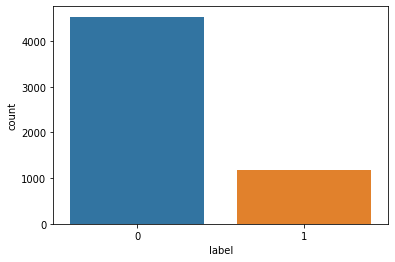

In [16]:
sns.countplot(label_2011_11);
label_2011_11.value_counts()

In [17]:
model_params = {
    'objective': 'binary', # 이진 분류
    'boosting_type': 'gbdt',
    'metric': 'auc', # 평가 지표 설정
    'feature_fraction': 0.8, # 피처 샘플링 비율
    'bagging_fraction': 0.8, # 데이터 샘플링 비율
    'bagging_freq': 1,
    'n_estimators': 10000, # 트리 개수
    'early_stopping_rounds': 100,
    'seed': SEED,
    'verbose': -1,
    'n_jobs': -1,    
}

In [20]:
train, test, y, features = feature_engineering1(data, '2011-11')
y_oof, test_preds_2011_11, fi = make_lgb_oof_prediction(train, y, test, features, model_params=model_params)
print_score(label_2011_11, test_preds_2011_11)

categorical feature: []
x_tr.shape (5501, 24) , x_te.shape (5722, 24)
fold: 1, x_tr.shape: (4950, 21), x_val.shape: (551, 21)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[20]	training's auc: 0.895988	valid_1's auc: 0.734418
Fold 1 | AUC: 0.7344182825484765
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (4951, 21), x_val.shape: (550, 21)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[17]	training's auc: 0.879575	valid_1's auc: 0.823652
Fold 2 | AUC: 0.8236515490854797
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (4951, 21), x_val.shape: (550, 21)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[26]	training's auc: 0.910012	valid_1's auc: 0.758807
Fold 3 | AUC: 0.7588069242254574
------------------------------------------------

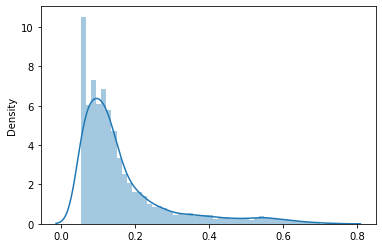

In [21]:
sns.distplot(test_preds_2011_11)
plt.show()

In [22]:
train, test, y, features = feature_engineering1(data, '2011-12')
y_oof, test_preds, fi = make_lgb_oof_prediction(train, y, test, features, model_params=model_params)

categorical feature: []
x_tr.shape (5722, 24) , x_te.shape (5914, 24)
fold: 1, x_tr.shape: (5149, 21), x_val.shape: (573, 21)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[24]	training's auc: 0.902047	valid_1's auc: 0.76602
Fold 1 | AUC: 0.7660200644134305
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 21), x_val.shape: (573, 21)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[35]	training's auc: 0.926121	valid_1's auc: 0.790915
Fold 2 | AUC: 0.790915485136786
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 21), x_val.shape: (572, 21)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[10]	training's auc: 0.852035	valid_1's auc: 0.794034
Fold 3 | AUC: 0.7940341969685657
--------------------------------------------------

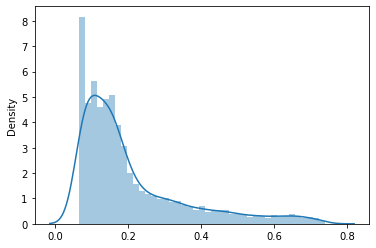

In [23]:
sns.distplot(test_preds)
plt.show()

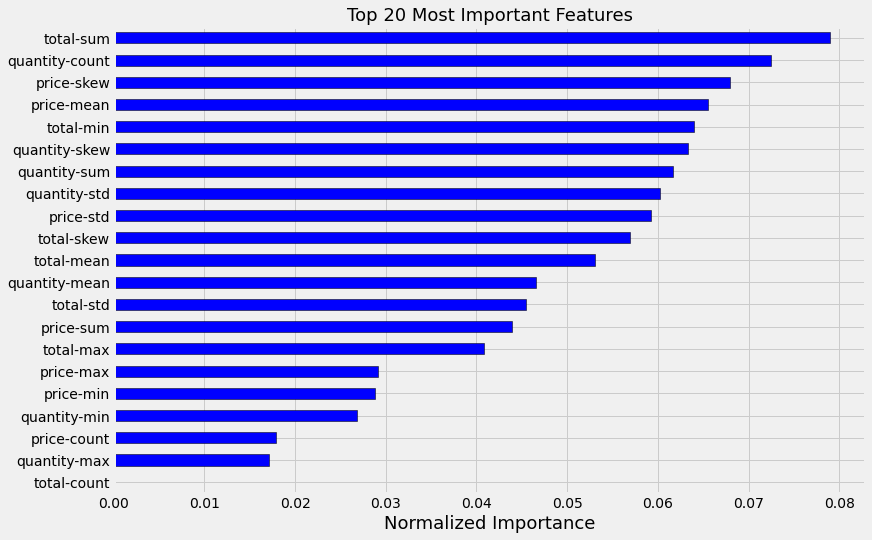

In [24]:
fi = plot_feature_importances(fi)

In [25]:
data_dir = '/opt/ml/code/input' # os.environ['SM_CHANNEL_TRAIN']
model_dir = '/opt/ml/code/model' # os.environ['SM_MODEL_DIR']
output_dir = '/opt/ml/code/output' # os.environ['SM_OUTPUT_DATA_DIR']

# 테스트 결과 제출 파일 읽기
sub = pd.read_csv(data_dir + '/sample_submission.csv')

# 테스트 예측 결과 저장
sub['probability'] = test_preds
print(sub['probability'].head())

os.makedirs(output_dir, exist_ok=True)
# 제출 파일 쓰기
sub.to_csv(os.path.join(output_dir , 'output.csv'), index=False) # /output.csv 라고 / 하면 안됨

# 자동 제출
# submit.py실행하기 

0    0.117355
1    0.253015
2    0.160883
3    0.355932
4    0.155720
Name: probability, dtype: float64


# 피처 생성 - (피처:누적합)

In [49]:
# def feature_generation(data,year_month): # 생성 후 aggregation까지 하는 코드. oof 하려면 변형했어야 됐음
#     df=data.copy()
    
#     df_label=generate_label(df,year_month)[['customer_id','year_month','label']]
#     df=df[df['order_date']<year_month]
    
#     df['cumsum_total_by_cust_id']=df.groupby(['customer_id'])['total'].cumsum()
#     df['cumsum_quantity_by_cust_id']=df.groupby(['customer_id'])['quantity'].cumsum()
#     df['cumsum_price_by_cust_id']=df.groupby(['customer_id'])['price'].cumsum()

#     df['cumsum_total_by_prod_id']=df.groupby(['product_id'])['total'].cumsum()
#     df['cumsum_quantity_by_prod_id']=df.groupby(['product_id'])['quantity'].cumsum()
#     df['cumsum_price_by_prod_id']=df.groupby(['product_id'])['price'].cumsum()
    
#     df['cumsum_total_by_order_id']=df.groupby(['order_id'])['total'].cumsum()
#     df['cumsum_quantity_by_order_id']=df.groupby(['order_id'])['quantity'].cumsum()
#     df['cumsum_price_by_order_id']=df.groupby(['order_id'])['price'].cumsum()
    
#     cols=[col for col in df.columns if 'cumsum' in col]
#     df_agg=df.groupby(['customer_id'])[cols].agg(['mean','max','min','sum','count','std','skew'])
    
#     new_cols = []
#     for col in df_agg.columns.levels[0]:
#         for stat in df_agg.columns.levels[1]:
#             new_cols.append(f'{col}-{stat}')
#     df_agg.columns=new_cols
    
#     df_all=df_label.merge(df_agg,on=['customer_id'],how='left')

#     return df_all

In [50]:
# df_cumsum_feature=feature_generation(data,'2011-11')

In [51]:
# df_cumsum_feature.head()

In [52]:
# sns.distplot(df_cumsum_feature.loc[df_cumsum_feature['label']==0,'cumsum_quantity_by_prod_id-sum'],label='label0')
# sns.distplot(df_cumsum_feature.loc[df_cumsum_feature['label']==1,'cumsum_quantity_by_prod_id-sum'],label='label1')
# plt.legend()
# plt.show()

In [53]:
def feature_generation_cumsum(df,year_month):
    df=data.copy()
    
    df['cumsum_total_by_cust_id']=df.groupby(['customer_id'])['total'].cumsum()
    df['cumsum_quantity_by_cust_id']=df.groupby(['customer_id'])['quantity'].cumsum()
    df['cumsum_price_by_cust_id']=df.groupby(['customer_id'])['price'].cumsum()

    df['cumsum_total_by_prod_id']=df.groupby(['product_id'])['total'].cumsum()
    df['cumsum_quantity_by_prod_id']=df.groupby(['product_id'])['quantity'].cumsum()
    df['cumsum_price_by_prod_id']=df.groupby(['product_id'])['price'].cumsum()
    
    df['cumsum_total_by_order_id']=df.groupby(['order_id'])['total'].cumsum()
    df['cumsum_quantity_by_order_id']=df.groupby(['order_id'])['quantity'].cumsum()
    df['cumsum_price_by_order_id']=df.groupby(['order_id'])['price'].cumsum()
    
    cols=[col for col in df.columns if 'cumsum' in col]

    return df,cols

In [54]:
def feature_engineering_cumsum(data, year_month):
    df = data.copy()
    
    # year_month 이전 월 계산
    d = datetime.datetime.strptime(year_month, "%Y-%m")
    prev_ym = d - dateutil.relativedelta.relativedelta(months=1)
    prev_ym = prev_ym.strftime('%Y-%m')
    
    # train, test 데이터 선택
    train = df[df['order_date'] < prev_ym]
    test = df[df['order_date'] < year_month]
    
    # train, test 레이블 데이터 생성
    train_label = generate_label(df, prev_ym)[['customer_id','year_month','label']]
    test_label = generate_label(df, year_month)[['customer_id','year_month','label']]
    
    # group by aggregation 함수 선언
    agg_func = ['mean','max','min','sum','count','std','skew']
    all_train_data = pd.DataFrame()
    
    for i, tr_ym in enumerate(train_label['year_month'].unique()):
        # group by aggretation 함수로 train 데이터 피처 생성
        
        train,cols=feature_generation_cumsum(train,year_month)
        train_agg = train.loc[train['order_date'] < tr_ym].groupby(['customer_id'])[cols].agg(agg_func)

        # 멀티 레벨 컬럼을 사용하기 쉽게 1 레벨 컬럼명으로 변경
        new_cols = []
        for col in train_agg.columns.levels[0]:
            for stat in train_agg.columns.levels[1]:
                new_cols.append(f'{col}-{stat}')

        train_agg.columns = new_cols
        train_agg.reset_index(inplace = True)
        
        train_agg['year_month'] = tr_ym
        
        all_train_data = all_train_data.append(train_agg)
    
    all_train_data = train_label.merge(all_train_data, on=['customer_id', 'year_month'], how='left')
    features = all_train_data.drop(columns=['customer_id', 'label', 'year_month']).columns
    
    # group by aggretation 함수로 test 데이터 피처 생성
    test,cols=feature_generation_cumsum(test,year_month)
    test_agg = test.groupby(['customer_id'])[cols].agg(agg_func)
    test_agg.columns = new_cols
    
    test_data = test_label.merge(test_agg, on=['customer_id'], how='left')
    
    # train, test 데이터 전처리
    x_tr, x_te = feature_preprocessing(all_train_data, test_data, features)
    
    print('x_tr.shape', x_tr.shape, ', x_te.shape', x_te.shape)
    
    return x_tr, x_te, all_train_data['label'], features

In [55]:
label_2011_11 = generate_label(data, '2011-11')['label']
train, test, y, features = feature_engineering_cumsum(data, '2011-11')
y_oof, test_preds_2011_11, fi = make_lgb_oof_prediction(train, y, test, features, model_params=model_params)
print_score(label_2011_11, test_preds_2011_11)

categorical feature: []
x_tr.shape (5501, 66) , x_te.shape (5722, 66)
fold: 1, x_tr.shape: (4950, 63), x_val.shape: (551, 63)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[24]	training's auc: 0.940938	valid_1's auc: 0.750416
Fold 1 | AUC: 0.750415512465374
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (4951, 63), x_val.shape: (550, 63)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[31]	training's auc: 0.954908	valid_1's auc: 0.848404
Fold 2 | AUC: 0.848404255319149
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (4951, 63), x_val.shape: (550, 63)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[63]	training's auc: 0.994339	valid_1's auc: 0.787491
Fold 3 | AUC: 0.7874906681597611
--------------------------------------------------

In [56]:
# 정보가 없는 12월 마지막으로 테스트 -> score metrics는 출력 불가
label_2011_12 = generate_label(data, '2011-12')['label']
train, test, y, features = feature_engineering_cumsum(data, '2011-12')
y_oof, test_preds_2011_12, fi = make_lgb_oof_prediction(train, y, test, features, model_params=model_params)

categorical feature: []
x_tr.shape (5722, 66) , x_te.shape (5914, 66)
fold: 1, x_tr.shape: (5149, 63), x_val.shape: (573, 63)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[3]	training's auc: 0.843858	valid_1's auc: 0.79781
Fold 1 | AUC: 0.7978103135527338
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 63), x_val.shape: (573, 63)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[12]	training's auc: 0.889198	valid_1's auc: 0.798902
Fold 2 | AUC: 0.798902380335394
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 63), x_val.shape: (572, 63)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[19]	training's auc: 0.909032	valid_1's auc: 0.827979
Fold 3 | AUC: 0.8279791682222055
---------------------------------------------------

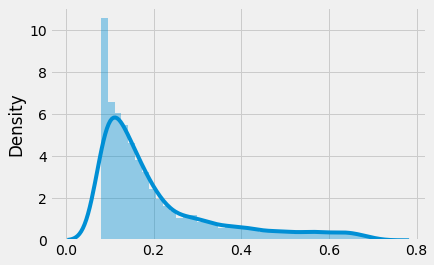

In [57]:
sns.distplot(test_preds_2011_12)
plt.show()

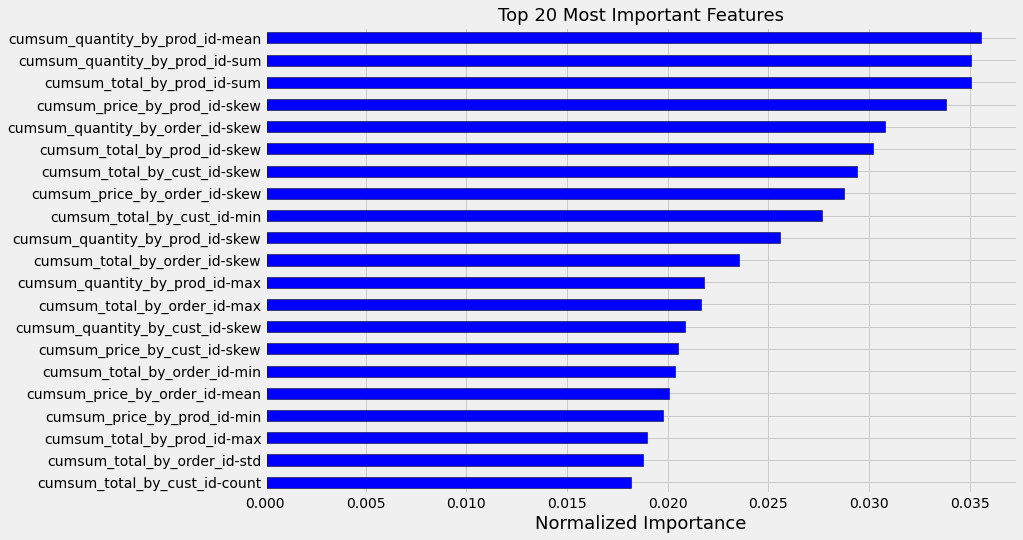

In [58]:
fi = plot_feature_importances(fi)

In [59]:
data_dir = '/opt/ml/code/input' # os.environ['SM_CHANNEL_TRAIN']
model_dir = '/opt/ml/code/model' # os.environ['SM_MODEL_DIR']
output_dir = '/opt/ml/code/output' # os.environ['SM_OUTPUT_DATA_DIR']

# 테스트 결과 제출 파일 읽기
sub = pd.read_csv(data_dir + '/sample_submission.csv')

# 테스트 예측 결과 저장
sub['probability'] = test_preds_2011_12
print(sub['probability'].head())

os.makedirs(output_dir, exist_ok=True)
# 제출 파일 쓰기
sub.to_csv(os.path.join(output_dir , 'output.csv'), index=False) # /output.csv 라고 / 하면 안됨

# 자동 제출
# submit.py실행하기 

0    0.127510
1    0.224987
2    0.177885
3    0.279993
4    0.123416
Name: probability, dtype: float64


In [60]:
# 결국, feature generation과 feature engineering만 변형하면서 사용 

# 피처 생성 - (피처:주문, 상품 데이터를 활용)

In [61]:
def feature_engineering_nunique(data, year_month):
    df = data.copy()
    
    # year_month 이전 월 계산
    d = datetime.datetime.strptime(year_month, "%Y-%m")
    prev_ym = d - dateutil.relativedelta.relativedelta(months=1)
    prev_ym = prev_ym.strftime('%Y-%m')
    
    # train, test 데이터 선택
    train = df[df['order_date'] < prev_ym]
    test = df[df['order_date'] < year_month]
    
    # train, test 레이블 데이터 생성
    train_label = generate_label(df, prev_ym)[['customer_id','year_month','label']]
    test_label = generate_label(df, year_month)[['customer_id','year_month','label']]
    
    # group by aggregation 함수 선언
    all_train_data = pd.DataFrame()
    
    # for feature generation
    cols=['order_id','product_id']
    
    for i, tr_ym in enumerate(train_label['year_month'].unique()):
        # group by aggretation 함수로 train 데이터 피처 생성
        train_agg = train.loc[train['order_date'] < tr_ym].groupby(['customer_id'])[cols].agg(['nunique'])

        # 멀티 레벨 컬럼을 사용하기 쉽게 1 레벨 컬럼명으로 변경
        new_cols = []
        for col in train_agg.columns.levels[0]:
            for stat in train_agg.columns.levels[1]:
                new_cols.append(f'{col}-{stat}')

        train_agg.columns = new_cols
        train_agg.reset_index(inplace = True)
        
        train_agg['year_month'] = tr_ym
        
        all_train_data = all_train_data.append(train_agg)
    
    all_train_data = train_label.merge(all_train_data, on=['customer_id', 'year_month'], how='left')
    features = all_train_data.drop(columns=['customer_id', 'label', 'year_month']).columns
    
    # group by aggretation 함수로 test 데이터 피처 생성
    test_agg = test.groupby(['customer_id'])[cols].agg(['nunique'])
    test_agg.columns = new_cols
    
    test_data = test_label.merge(test_agg, on=['customer_id'], how='left')

    # train, test 데이터 전처리
    x_tr, x_te = feature_preprocessing(all_train_data, test_data, features)
    
    print('x_tr.shape', x_tr.shape, ', x_te.shape', x_te.shape)
    
    return x_tr, x_te, all_train_data['label'], features

In [62]:
label_2011_11 = generate_label(data, '2011-11')['label']
train, test, y, features = feature_engineering_nunique(data, '2011-11')
y_oof, test_preds_2011_11, fi = make_lgb_oof_prediction(train, y, test, features, model_params=model_params)
print_score(label_2011_11, test_preds_2011_11)

categorical feature: []
x_tr.shape (5501, 5) , x_te.shape (5722, 5)
fold: 1, x_tr.shape: (4950, 2), x_val.shape: (551, 2)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[7]	training's auc: 0.791894	valid_1's auc: 0.739335
Fold 1 | AUC: 0.7393351800554016
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (4951, 2), x_val.shape: (550, 2)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[11]	training's auc: 0.788702	valid_1's auc: 0.83275
Fold 2 | AUC: 0.8327500933184024
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (4951, 2), x_val.shape: (550, 2)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[5]	training's auc: 0.790802	valid_1's auc: 0.750163
Fold 3 | AUC: 0.7501633072041807
-----------------------------------------------------------

In [63]:
# 정보가 없는 12월 마지막으로 테스트 -> score metrics는 출력 불가
label_2011_12 = generate_label(data, '2011-12')['label']
train, test, y, features = feature_engineering_nunique(data, '2011-12')
y_oof, test_preds_2011_12, fi = make_lgb_oof_prediction(train, y, test, features, model_params=model_params)

categorical feature: []
x_tr.shape (5722, 5) , x_te.shape (5914, 5)
fold: 1, x_tr.shape: (5149, 2), x_val.shape: (573, 2)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[25]	training's auc: 0.816281	valid_1's auc: 0.750518
Fold 1 | AUC: 0.7505182689816013
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 2), x_val.shape: (573, 2)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[2]	training's auc: 0.784231	valid_1's auc: 0.790379
Fold 2 | AUC: 0.7903787065486987
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 2), x_val.shape: (572, 2)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[10]	training's auc: 0.795556	valid_1's auc: 0.816126
Fold 3 | AUC: 0.8161259613230791
---------------------------------------------------------

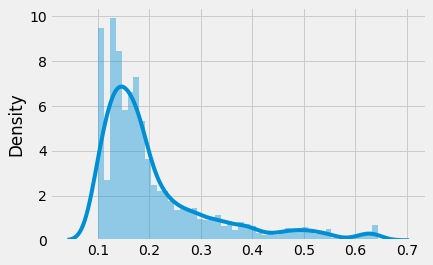

In [64]:
sns.distplot(test_preds_2011_12)
plt.show()

# 피처 생성 - (피처:월/년월 특성)

In [65]:
def feature_generation_m_ym(df,year_month):
    df=data.copy()
      
    df['month']=df['order_date'].dt.month
    df['year_month']=df['order_date'].dt.strftime('%Y-%m')

    cols=['month','year_month']

    return df,cols

In [68]:
def feature_engineering_m_ym(data, year_month):
    df = data.copy()
    
    # year_month 이전 월 계산
    d = datetime.datetime.strptime(year_month, "%Y-%m")
    prev_ym = d - dateutil.relativedelta.relativedelta(months=1)
    prev_ym = prev_ym.strftime('%Y-%m')
    
    # train, test 데이터 선택
    train = df[df['order_date'] < prev_ym]
    test = df[df['order_date'] < year_month]
    
    # train, test 레이블 데이터 생성
    train_label = generate_label(df, prev_ym)[['customer_id','year_month','label']]
    test_label = generate_label(df, year_month)[['customer_id','year_month','label']]
    
    # group by aggregation 함수 선언
    all_train_data = pd.DataFrame()
    
    for i, tr_ym in enumerate(train_label['year_month'].unique()):
        # group by aggretation 함수로 train 데이터 피처 생성
        
        train,cols=feature_generation_m_ym(train,year_month)
        train_agg = train.loc[train['order_date'] < tr_ym].groupby(['customer_id'])[cols].agg([lambda x : x.value_counts().index[0]])

        train_agg.columns = ['month-mode','year_month-mode']
        train_agg.reset_index(inplace = True)
        
        train_agg['year_month'] = tr_ym
        
        all_train_data = all_train_data.append(train_agg)
    
    all_train_data = train_label.merge(all_train_data, on=['customer_id', 'year_month'], how='left')
    features = all_train_data.drop(columns=['customer_id', 'label', 'year_month']).columns
    
    # group by aggretation 함수로 test 데이터 피처 생성
    test,cols=feature_generation_m_ym(test,year_month)
    test_agg = test.groupby(['customer_id'])[cols].agg([lambda x : x.value_counts().index[0]])
    test_agg.columns = ['month-mode','year_month-mode']
    
    test_data = test_label.merge(test_agg, on=['customer_id'], how='left')
    
    # train, test 데이터 전처리
    x_tr, x_te = feature_preprocessing(all_train_data, test_data, features)
    
    print('x_tr.shape', x_tr.shape, ', x_te.shape', x_te.shape)
    
    return x_tr, x_te, all_train_data['label'], features

In [69]:
label_2011_11 = generate_label(data, '2011-11')['label']
train, test, y, features = feature_engineering_m_ym(data, '2011-11')
y_oof, test_preds_2011_11, fi = make_lgb_oof_prediction(train, y, test, features, model_params=model_params)
print_score(label_2011_11, test_preds_2011_11)

categorical feature: ['year_month-mode']
x_tr.shape (5501, 5) , x_te.shape (5722, 5)
fold: 1, x_tr.shape: (4950, 2), x_val.shape: (551, 2)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[13]	training's auc: 0.63314	valid_1's auc: 0.584095
Fold 1 | AUC: 0.5840951061865189
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (4951, 2), x_val.shape: (550, 2)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[18]	training's auc: 0.627988	valid_1's auc: 0.654092
Fold 2 | AUC: 0.6540920119447556
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (4951, 2), x_val.shape: (550, 2)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[83]	training's auc: 0.643414	valid_1's auc: 0.583882
Fold 3 | AUC: 0.5838815789473684
----------------------------------------

In [70]:
# 정보가 없는 12월 마지막으로 테스트 -> score metrics는 출력 불가
label_2011_12 = generate_label(data, '2011-12')['label']
train, test, y, features = feature_engineering_m_ym(data, '2011-12')
y_oof, test_preds_2011_12, fi = make_lgb_oof_prediction(train, y, test, features, model_params=model_params)

categorical feature: ['year_month-mode']
x_tr.shape (5722, 5) , x_te.shape (5914, 5)
fold: 1, x_tr.shape: (5149, 2), x_val.shape: (573, 2)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[55]	training's auc: 0.676538	valid_1's auc: 0.641126
Fold 1 | AUC: 0.6411264946507237
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 2), x_val.shape: (573, 2)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[5]	training's auc: 0.662617	valid_1's auc: 0.654444
Fold 2 | AUC: 0.6544441565172325
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 2), x_val.shape: (572, 2)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[49]	training's auc: 0.675831	valid_1's auc: 0.636265
Fold 3 | AUC: 0.6362652131710596
----------------------------------------

# 피처 생성 - (피처:time series diff)

In [72]:
def feature_generation_time_series_diff(df,year_month):
    df=data.copy()
    
    df['order_ts']=df['order_date'].astype(np.int64)//1e9
    df['order_ts_diff']=df.groupby(['customer_id'])['order_ts'].diff()
    df['quantity_diff']=df.groupby(['customer_id'])['quantity'].diff()
    df['price_diff']=df.groupby(['customer_id'])['price'].diff()
    df['total_diff']=df.groupby(['customer_id'])['total'].diff()
    
    return df

In [73]:
def feature_engineering_time_series_diff(data, year_month):
    df = data.copy()
    
    # year_month 이전 월 계산
    d = datetime.datetime.strptime(year_month, "%Y-%m")
    prev_ym = d - dateutil.relativedelta.relativedelta(months=1)
    prev_ym = prev_ym.strftime('%Y-%m')
    
    # train, test 데이터 선택
    train = df[df['order_date'] < prev_ym]
    test = df[df['order_date'] < year_month]
    
    # train, test 레이블 데이터 생성
    train_label = generate_label(df, prev_ym)[['customer_id','year_month','label']]
    test_label = generate_label(df, year_month)[['customer_id','year_month','label']]
    
    # group by aggregation 함수 선언
    agg_func = ['mean','max','min','sum','count','std','skew']
    agg_dict = {
        'order_ts':['first','last'],
        'order_ts_diff':agg_func,
        'quantity_diff':agg_func,
        'price_diff':agg_func,
        'total_diff':agg_func,
    }
    
    all_train_data = pd.DataFrame()
    
    for i, tr_ym in enumerate(train_label['year_month'].unique()):
        # group by aggretation 함수로 train 데이터 피처 생성
        train=feature_generation_time_series_diff(train,year_month)
        train_agg = train.loc[train['order_date'] < tr_ym].groupby(['customer_id']).agg(agg_dict)

        # 멀티 레벨 컬럼을 사용하기 쉽게 1 레벨 컬럼명으로 변경
        new_cols = []
        for col in agg_dict.keys():
            for stat in agg_dict[col]:
                new_cols.append(f'{col}-{stat}')
                
        train_agg.columns = new_cols
        train_agg.reset_index(inplace = True)
        
        train_agg['year_month'] = tr_ym
        
        all_train_data = all_train_data.append(train_agg)
    
    all_train_data = train_label.merge(all_train_data, on=['customer_id', 'year_month'], how='left')
    features = all_train_data.drop(columns=['customer_id', 'label', 'year_month']).columns
    
    # group by aggretation 함수로 test 데이터 피처 생성
    test=feature_generation_time_series_diff(test,year_month)
    test_agg = test.groupby(['customer_id']).agg(agg_dict)
    test_agg.columns = new_cols
    
    test_data = test_label.merge(test_agg, on=['customer_id'], how='left')
    
    # train, test 데이터 전처리
    x_tr, x_te = feature_preprocessing(all_train_data, test_data, features)
    
    print('x_tr.shape', x_tr.shape, ', x_te.shape', x_te.shape)
    
    return x_tr, x_te, all_train_data['label'], features

In [74]:
label_2011_11 = generate_label(data, '2011-11')['label']
train, test, y, features = feature_engineering_time_series_diff(data, '2011-11')
y_oof, test_preds_2011_11, fi = make_lgb_oof_prediction(train, y, test, features, model_params=model_params)
print_score(label_2011_11, test_preds_2011_11)

categorical feature: []
x_tr.shape (5501, 33) , x_te.shape (5722, 33)
fold: 1, x_tr.shape: (4950, 30), x_val.shape: (551, 30)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[5]	training's auc: 0.844507	valid_1's auc: 0.765963
Fold 1 | AUC: 0.7659626038781162
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (4951, 30), x_val.shape: (550, 30)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[27]	training's auc: 0.933345	valid_1's auc: 0.847261
Fold 2 | AUC: 0.8472611048898843
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (4951, 30), x_val.shape: (550, 30)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[12]	training's auc: 0.883215	valid_1's auc: 0.793311
Fold 3 | AUC: 0.7933114035087719
-------------------------------------------------

In [75]:
# 정보가 없는 12월 마지막으로 테스트 -> score metrics는 출력 불가
label_2011_12 = generate_label(data, '2011-12')['label']
train, test, y, features = feature_engineering_time_series_diff(data, '2011-12')
y_oof, test_preds_2011_12, fi = make_lgb_oof_prediction(train, y, test, features, model_params=model_params)

categorical feature: []
x_tr.shape (5722, 33) , x_te.shape (5914, 33)
fold: 1, x_tr.shape: (5149, 30), x_val.shape: (573, 30)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[36]	training's auc: 0.946408	valid_1's auc: 0.809425
Fold 1 | AUC: 0.809425091622552
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 30), x_val.shape: (573, 30)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[10]	training's auc: 0.8802	valid_1's auc: 0.80564
Fold 2 | AUC: 0.805639877096213
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 30), x_val.shape: (572, 30)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[60]	training's auc: 0.980797	valid_1's auc: 0.819215
Fold 3 | AUC: 0.8192152617038753
-----------------------------------------------------

In [76]:
data_dir = '/opt/ml/code/input' # os.environ['SM_CHANNEL_TRAIN']
model_dir = '/opt/ml/code/model' # os.environ['SM_MODEL_DIR']
output_dir = '/opt/ml/code/output' # os.environ['SM_OUTPUT_DATA_DIR']

# 테스트 결과 제출 파일 읽기
sub = pd.read_csv(data_dir + '/sample_submission.csv')

# 테스트 예측 결과 저장
sub['probability'] = test_preds_2011_12
print(sub['probability'].head())

os.makedirs(output_dir, exist_ok=True)
# 제출 파일 쓰기
sub.to_csv(os.path.join(output_dir , 'output.csv'), index=False) # /output.csv 라고 / 하면 안됨

# 자동 제출
# submit.py실행하기 

0    0.138558
1    0.262294
2    0.157755
3    0.171697
4    0.085277
Name: probability, dtype: float64


In [ ]:
# 현재까지는 time_series_diff가 가장 성능이 잘 나옴